# Notebook for analysing behavior at optogenetic stimulus border

### Assumes use of FlyOver version 9.4 or higher (closed-loop optogenetic stimulation possible)
### Data from multiple trials and flies is pooled and collected in a single data frame, which is then used for data visualisation and statistics.

In [160]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep, exists
from sys import path, exit
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec, rcParams
import matplotlib.patches as ptchs

import seaborn as sns

from scipy import stats as sts
from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

from flyVR.flyVRoptogenetics.flyVRoptogenetics_oneTrialBasicAnalysis import singleVROptogenTrialAnalysis
from flyVR.utilities.loadObjectCoords import loadObjectCoords
from flyVR.utilities.loadSingleTrial import rZoneParamsFromLogFile

from trajectoryAnalysis.trajectoryDerivedParams import relationToObject, cartesian2polar

from plottingUtilities.basicPlotting import myAxisTheme,_myAccentList
from plottingUtilities.objectInteractionPlots import plotWalkingVelocityDistr
from plottingUtilities.plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df,\
            plotVeloHeadingDistribution2_flyVR_df,oneDimResidencyWithVar_df
from plottingUtilities.objectPreferencePlots import countvisits, diffCorrPlot, prettyBoxPlot, simpleBoxPlot

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [206]:
# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25', 'm26']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [207]:
#my_indices = [2,3,4,7,8,9,10,12,13,14,15,16,19,20]
#expDirs = [expDirs[i] for i in my_indices]
expDirs = expDirs[:25]
print(expDirs)

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25']


### Compose mutli-fly data into dataframe

In [208]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

In [209]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [210]:
keylist = ['curvature','gamma','gammaFull','headingAngle','objectDistance','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','rEvents']

keylistLong = ['flyID','trial','trialtype','reinforcement','moving'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

nTrialsVI = 0
nTrialsIN = 0
nTrialsR = 0
nTrialsNR = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:
        
        flyID = fileToAnalyse.split('_')[4]
        genotype = fileToAnalyse.split('_')[3]
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleVROptogenTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'Invisible' in fileToAnalyse or 'invisible' in fileToAnalyse:
            trialtype = 'invisible'
            nTrialsIN += 1
        else:
            trialtype = 'visible'
            nTrialsVI += 1
        
        if 'rZones' in fileToAnalyse:
            rZones = 'on'
            nTrialsR += 1
        else:
            rZones = 'off'
            nTrialsNR += 1
        
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH

        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'reinforcement', rZones)
        FODatLoad_df.insert(4, 'moving', moving)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/lowContrast/HC-Gal4_x_10ChrRWTB_retinal/noBL-30max/males/rawData/m01/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHexLED40mm30per_HCx10ChrRWTB_m01_9-10d_none_out_161216171645.txt', 'singleObjectForest_1cm4cmCone_12cmHexLED40mm30per_HCx10ChrRWTB_m01_9-10d_none_out_161216174524.txt', 'singleObjectForest_1cm4cmCone_12cmHexLED40mm30per_HCx10ChrRWTB_m01_9-10d_rZones_out_161216172831.txt', 'singleObjectForest_1cm4cmInvisibleCone_12cmHexLED40mm30per_HCx10ChrRWTB_m01_9-10d_rZones_out_161216175647.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/lowContrast/HC-Gal4_x_10ChrRWTB_retinal/noBL-30max/males/rawData/m02/

 Analysing the following log files:

['singleObjectFo

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/lowContrast/HC-Gal4_x_10ChrRWTB_retinal/noBL-30max/males/rawData/m12/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHexLED40mm30per_HCx10ChrRWTB_m12_7-8d_none_out_161220170236.txt', 'singleObjectForest_1cm4cmCone_12cmHexLED40mm30per_HCx10ChrRWTB_m12_7-8d_none_out_161220173747.txt', 'singleObjectForest_1cm4cmCone_12cmHexLED40mm30per_HCx10ChrRWTB_m12_7-8d_rZones_out_161220171331.txt', 'singleObjectForest_1cm4cmInvisibleCone_12cmHexLED40mm30per_HCx10ChrRWTB_m12_7-8d_rZones_out_161220175015.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/lowContrast/HC-Gal4_x_10ChrRWTB_retinal/noBL-30max/males/rawData/m13/

 Anal

Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/lowContrast/HC-Gal4_x_10ChrRWTB_retinal/noBL-30max/males/rawData/m23/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHexLED40mm30per_HCx10ChrRWTB_m23_6-7d_none_out_170118172305.txt', 'singleObjectForest_1cm4cmCone_12cmHexLED40mm30per_HCx10ChrRWTB_m23_6-7d_none_out_170118174458.txt', 'singleObjectForest_1cm4cmCone_12cmHexLED40mm30per_HCx10ChrRWTB_m23_6-7d_rZones_out_170118173404.txt', 'singleObjectForest_1cm4cmInvisibleCone_12cmHexLED40mm30per_HCx10ChrRWTB_m23_6-7d_rZones_out_170118171209.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObjOpto/circularZones/lowContrast/HC-Gal4_x_10ChrRWTB_retinal/noBL-30max

In [211]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')
FOAllFlies_df['reinforcement'] = FOAllFlies_df['reinforcement'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,reinforcement,moving,curvature,gamma,gammaFull,headingAngle,objectDistance,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,rEvents
0,m01,1.0,visible,off,0.0,NaN,NaN,NaN,-0.000004,NaN,0.000000,0.000000,0.000000,60.622000,NaN,35.000000,NaN,0.0
1,m01,1.0,visible,off,0.0,NaN,NaN,NaN,-0.000004,NaN,0.000000,0.050005,0.000000,60.622000,NaN,35.000000,NaN,0.0
2,m01,1.0,visible,off,0.0,NaN,NaN,NaN,-0.000004,NaN,0.000000,0.100011,0.000000,60.622000,NaN,35.000000,NaN,0.0
3,m01,1.0,visible,off,0.0,NaN,NaN,NaN,-0.000004,NaN,0.000000,0.150016,0.000000,60.622000,NaN,35.000000,NaN,0.0
4,m01,1.0,visible,off,0.0,NaN,NaN,NaN,-0.000004,NaN,0.000000,0.200021,0.000000,60.622000,NaN,35.000000,NaN,0.0
5,m01,1.0,visible,off,0.0,NaN,NaN,NaN,-0.000004,NaN,0.000000,0.250026,0.000000,60.622000,NaN,35.000000,NaN,0.0
6,m01,1.0,visible,off,0.0,NaN,NaN,NaN,-0.000004,NaN,0.157139,0.300032,0.789919,60.622000,NaN,35.000000,NaN,0.0
7,m01,1.0,visible,off,0.0,NaN,NaN,NaN,0.007854,NaN,0.471189,0.350037,0.000000,60.652500,NaN,35.025100,NaN,0.0
8,m01,1.0,visible,off,0.0,NaN,NaN,NaN,0.031416,NaN,1.570631,0.400042,1.607147,60.652500,NaN,35.025100,NaN,0.0
9,m01,1.0,visible,off,1.0,NaN,NaN,NaN,0.109956,NaN,2.827136,0.450047,2.299582,60.617000,NaN,35.097200,NaN,0.0


In [212]:
flyIDallarray = FOAllFlies_df['flyID'].values
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Define structure of trials in terms of closed-loop optogenetic stimulation and presence of landmark cues

In [213]:
# Reinforcement test
rZoneState = ['off','off','on','on']
visibilityState = ['visible','visible','visible','invisible']
groundPlane = ['textured']
trialOrder = [0,2,1,3]
trialName = ['obj (1)','obj (3)','obj + opt (2)','opt (4)']
arenaRad = 60

condName = ['objPre','objPost','objOpt','optAlone']
trialCol = ['teal', 'mediumseagreen','m','salmon']

rZone_rInner, rZone_rOuter, rZone_max, rZone_bl, rZone_gExp = rZoneParamsFromLogFile(expDir, fileToAnalyse)

In [214]:
%matplotlib inline 

### Residency

In [215]:
resdf_keylist_short = ['flyID','reinforcement','moving','time']
resdf_keylist = resdf_keylist_short + ['dist2LM', 'condition']

residency_df = pd.DataFrame(data=np.zeros((0,len(resdf_keylist))), columns=resdf_keylist)
for trial in range(4):
    for fly in range(len(flyIDs)):
        querystring = '(flyID == "'+flyIDs[fly]+'") & (trial =='+str(trial+1)+')'
        xtrial = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()

        # compute distance to closest landmark for each type
        dist2LM = np.hypot(xtrial,ytrial)
        tmpdf = FOAllFlies_df.query(querystring)[resdf_keylist_short]
        tmpdf.insert(1,'dist2LM', dist2LM)
        tmpdf.insert(1,'condition', condName[trial])

        residency_df = residency_df.append(tmpdf)

residency_df = residency_df[resdf_keylist]

In [216]:
residency_df.head()

,flyID,reinforcement,moving,time,dist2LM,condition
0,m01,off,0.0,0.000000,NaN,objPre
1,m01,off,0.0,0.050005,NaN,objPre
2,m01,off,0.0,0.100011,NaN,objPre
3,m01,off,0.0,0.150016,NaN,objPre
4,m01,off,0.0,0.200021,NaN,objPre


Plot directory already exists


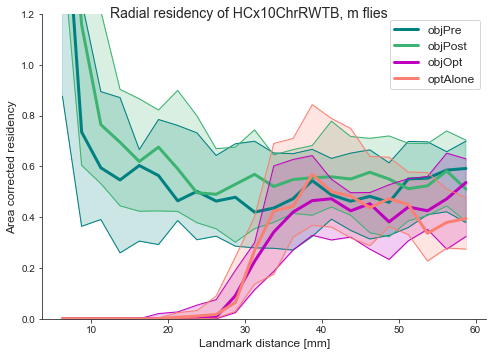

In [217]:
try:
    mkdir(analysisDir + 'residencyPlots/')
except:
    print('Plot directory already exists')

movementFilter = 'moving > 0'
numBins = 22
histRange = (5,arenaRad)
varStyle = 'iqr' #'std', 'iqr' 'dotplot'
fill = False

# log residency
radResFig, ax = plt.subplots(1,1,figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotype+', '+flyIDs[0][0]+' flies',fontsize=14)

ax = oneDimResidencyWithVar_df(ax, residency_df, flyIDs, movementFilter, numBins, histRange, 1, False, 
                               varStyle, 1, trialCol, condName)
ax.set_ylim(0,1.2)
myAxisTheme(ax)
radResFig.tight_layout()
radResFig.savefig(analysisDir + 'residencyPlots/'+ genotype +'_'+flyIDs[0][0]
                    + '_radialResidencyVar_'+varStyle+'_lin_n'+ str(len(flyIDs)) +'_v2fine.pdf', format='pdf')

### Characterise turns at border of virtual heat zone

fly: m13
Analysis directory already exists.


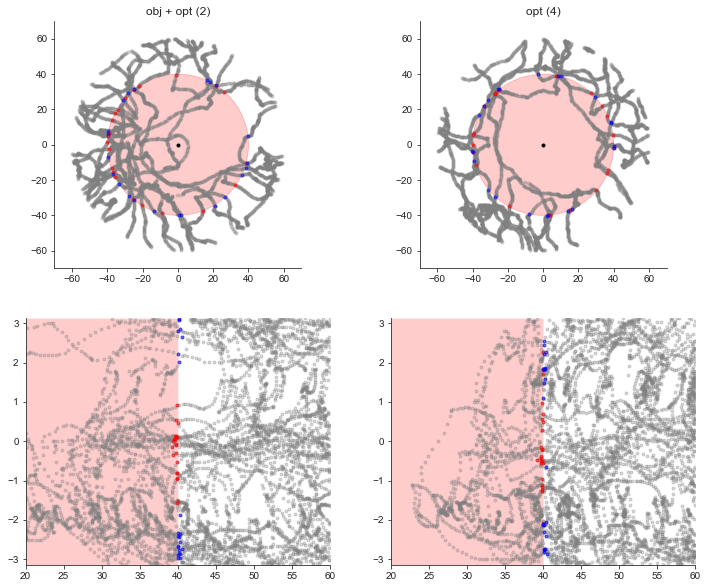

In [218]:
fly = 12
print('fly: '+flyIDs[fly])

visitRad = rZone_rOuter

borderFig, splts = plt.subplots(2, 2, figsize=(12,10))

for tind,trial in enumerate([3,4]):
    traj = splts[0, tind]
    pol = splts[1, tind]
    rZonePlt = plt.Circle((0,0),rZone_rOuter,color='red',alpha=0.2)
    
    flyDf = FOAllFlies_df.query('(moving > 0) & (flyID=="'+flyIDs[fly]+'") & (trial=='+str(trial)+')')
    flyx = flyDf['xPosInMiniarena'].values.squeeze().astype('float')
    flyy = flyDf['yPosInMiniarena'].values.squeeze().astype('float')
    flyh = flyDf['headingAngle'].values.squeeze().astype('float')
    flyg = flyDf['gammaFull'].values.squeeze().astype('float')
    flyt = flyDf['time'].values.squeeze().astype('float')
    
    flyOD = np.hypot(flyx,flyy)
    flyOD_d = np.hstack((0,np.diff(flyOD)))
    
    entries, exits, visitT, entryTime, exitTime = countvisits(flyOD,flyt,visitRad)

    traj.plot(flyx, flyy,'.',color = 'grey', alpha=0.3)
    traj.plot(flyx[entries], flyy[entries],'.',color = 'red', alpha=0.5)
    traj.plot(flyx[exits], flyy[exits],'.',color = 'blue', alpha=0.5)
    traj.add_artist(rZonePlt)
    traj.plot(0,0,'.',color='black')
    traj.axis([-arenaRad-10, arenaRad+10, -arenaRad-10, arenaRad+10])
    traj.set_aspect('equal')
    traj.set_title(trialName[trial-1])
    myAxisTheme(traj)
    
    pol.plot(flyOD, flyg,'.',color = 'grey', alpha=0.3)

    pol.plot(flyOD[entries], flyg[entries],'.',color = 'red', alpha=0.5)
    pol.plot(flyOD[exits], flyg[exits],'.',color = 'blue', alpha=0.5)
    pol.set_xlim(20,arenaRad)
    pol.set_ylim(-np.pi,np.pi)
    
    pol.add_patch(
        ptchs.Rectangle(
            (0, -np.pi),   # (x,y)
            rZone_rOuter,  # width
            2*np.pi,    # height
            facecolor='red',
            alpha=0.2
        )
    )
    myAxisTheme(pol)
    
try:
    mkdir(analysisDir + sep + 'borderZone' + sep)
except OSError:
    print('Analysis directory already exists.')

borderFig.savefig(analysisDir + 'borderZone/'  + genotype
                   + '_trajInTransitionZone_fly'+ flyIDs[fly] +'.pdf', format='pdf')  

In [219]:
visitRad = rZone_rOuter-5
preWindow = int(20*-0.0)#-0.5
postWindow = int(20*2.0) #2.0 #2.5

windowSize = int(abs(preWindow)+postWindow)

In [220]:
def transitionTrajPlots(x, y, od, g, eventpts, eventlabel, eventsplts, xlimits):
    
    fragm = eventsplts[0,tind]
    polfragm = eventsplts[1,tind]
    headfragm = eventsplts[2,tind]
    
    for event in eventpts:
        fragm.plot(x[event+preWindow:event+postWindow],y[event+preWindow:event+postWindow],'.',alpha=0.5)
        fragm.plot(x[event],y[event],'k.',alpha=0.5)
        fragm.plot(0,0,'.',color='black')
        fragm.axis([-rZone_rOuter-10, rZone_rOuter+10, -rZone_rOuter-10, rZone_rOuter+10])
        fragm.set_aspect('equal')
        fragm.set_title(eventlabel + ' in trial ' + trialName[trial-1],fontsize=12)
        myAxisTheme(fragm)
    
        polfragm.plot(od[event+preWindow:event+postWindow],abs(g[event+preWindow:event+postWindow]),'-',alpha=0.5)
        polfragm.plot(od[event],abs(g[event]),'k.',alpha=0.5)
        polfragm.set_xlim(xlimits)
        polfragm.set_ylim(0,np.pi)
        polfragm.set_xlabel('landmark distance [mm]')
        polfragm.set_ylabel('relative heading [rad]')
        myAxisTheme(polfragm)
        
        headfragm.plot(abs(g[event+preWindow:event+postWindow]),'-',alpha=0.5)
        headfragm.plot(abs(preWindow),abs(g[event]),'k.',alpha=0.5)
        headfragm.set_ylim(0,np.pi)
        headfragm.set_xlabel('time [frames]')
        headfragm.set_ylabel('relative heading [rad]')
        myAxisTheme(headfragm)
    
    return eventsplts

fly: m05


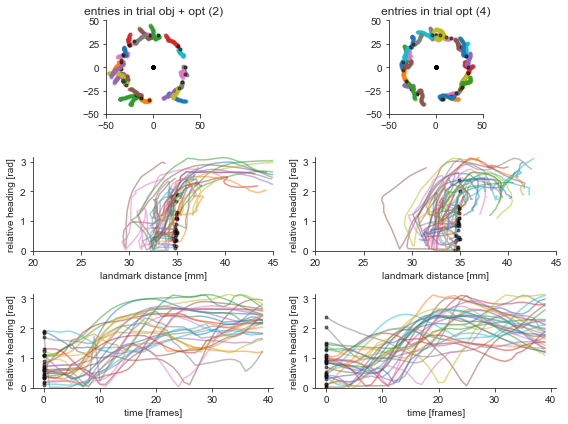

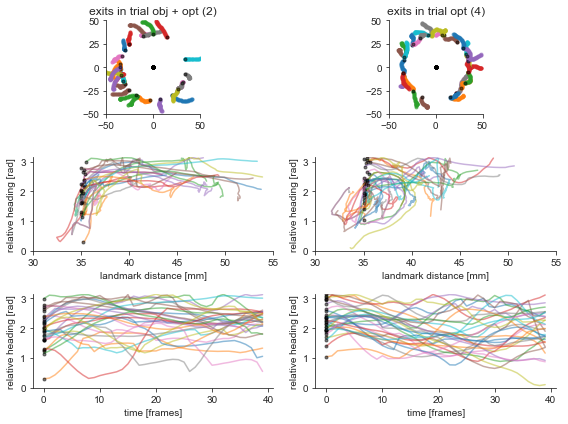

In [221]:
fly = 4

entryFig, entrysplts = plt.subplots(3, 2, figsize=(8,6))
exitFig, exitsplts = plt.subplots(3, 2, figsize=(8,6))

print('fly: '+flyIDs[fly])

import matplotlib.patches as ptchs

for tind,trial in enumerate([3,4]):
    flyDf = FOAllFlies_df.query('(moving > 0) & (flyID=="'+flyIDs[fly]+'") & (trial=='+str(trial)+')')
    flyx = flyDf['xPosInMiniarena'].values.squeeze().astype('float')
    flyy = flyDf['yPosInMiniarena'].values.squeeze().astype('float')
    flyg = flyDf['gammaFull'].values.squeeze().astype('float')
    flyt = flyDf['time'].values.squeeze().astype('float')
    
    flyOD = np.hypot(flyx,flyy)
    
    entries, exits, visitT,entryTime,exitTime = countvisits(flyOD,flyt,visitRad)

    entrypts = [i for i, x in enumerate(entries) if x]
    exitpts = [i for i, x in enumerate(exits) if x]
    
    entrysplts = transitionTrajPlots(flyx, flyy, flyOD, flyg, entrypts, 'entries', entrysplts, [20,rZone_rOuter+5])
    exitsplts = transitionTrajPlots(flyx, flyy, flyOD, flyg, exitpts, 'exits', exitsplts, [30,rZone_rOuter+15])
    
entryFig.tight_layout()
exitFig.tight_layout()

entryFig.savefig(analysisDir + 'borderZone/'  + genotype
                   + '_entryTrajectories_fly'+ flyIDs[fly] +'.pdf', format='pdf')  
exitFig.savefig(analysisDir + 'borderZone/'  + genotype
                   + '_exitTrajectories_fly'+ flyIDs[fly] +'.pdf', format='pdf')  

#### Plot median exit and entry trajectory

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


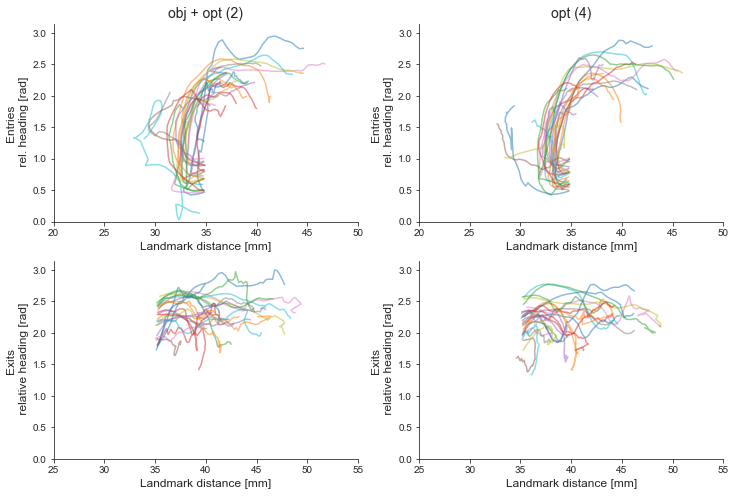

In [222]:
# all flies

avTraj = plt.figure(figsize=(12,8))

for tind,trial in enumerate([3,4]):
    entryPlt = avTraj.add_subplot(2,2,1+tind)
    exitPlt = avTraj.add_subplot(2,2,3+tind)
        
    for fly in range(len(flyIDs)):
        flyDf = FOAllFlies_df.query('(moving > 0) & (flyID=="'+flyIDs[fly]+'") & (trial=='+str(trial)+')')
        flyx = flyDf['xPosInMiniarena'].values.squeeze().astype('float')
        flyy = flyDf['yPosInMiniarena'].values.squeeze().astype('float')
        flyg = flyDf['gammaFull'].values.squeeze().astype('float')
        flyt = flyDf['time'].values.squeeze().astype('float')

        flyOD = np.hypot(flyx,flyy)

        entries, exits, visitT,entryTime,exitTime = countvisits(flyOD,flyt,visitRad)

        entrypts = [i for i, x in enumerate(entries) if x]
        exitpts = [i for i, x in enumerate(exits) if x]
        timevec = np.array(range(int(windowSize)))

        entryFragms = np.nan*np.ones((2,len(entrypts),windowSize))
        exitFragms = np.nan*np.ones((2,len(exitpts),windowSize))
        timeVecEntry = np.nan*np.ones((len(entrypts),windowSize))
        timeVecExit = np.nan*np.ones((len(exitpts),windowSize))
        
        #entries
        for ind, entry in enumerate(entrypts[:-1]):
            entryFragms[0,ind,:] = abs(flyg[entry+preWindow:entry+postWindow])
            entryFragms[1,ind,:] = flyOD[entry+preWindow:entry+postWindow]
            timeVecEntry[ind,:] = timevec
            
        #exits
        for ind, exit in enumerate(exitpts[:-1]):
            exitFragms[0,ind,:] = abs(flyg[exit+preWindow:exit+postWindow])
            exitFragms[1,ind,:] = flyOD[exit+preWindow:exit+postWindow]
            timeVecExit[ind,:] = timevec
                    
        entryPlt.plot(np.nanmean(entryFragms[1,:,:],0),
                      np.nanmean(entryFragms[0,:,:],0),'-', alpha=0.5)
        
        exitPlt.plot(np.nanmean(exitFragms[1,:,:],0),
                     np.nanmean(exitFragms[0,:,:],0),'-', alpha=0.5)
    
    entryPlt.set_xlabel('Landmark distance [mm]', fontsize=12)
    entryPlt.set_ylabel('Entries \n rel. heading [rad]',fontsize=12)
    entryPlt.set_title(trialName[trial-1],fontsize=14)
    entryPlt.set_xlim(20,50)
    entryPlt.set_ylim(0,np.pi)
    myAxisTheme(entryPlt)
    
    exitPlt.set_xlabel('Landmark distance [mm]', fontsize=12)
    exitPlt.set_ylabel('Exits \n relative heading [rad]', fontsize=12)
    exitPlt.set_xlim(25,55)
    exitPlt.set_ylim(0,np.pi)
    myAxisTheme(exitPlt)
        

### Extract entry and exist path segments; compute curvature of path segments

In [223]:
def signedCurvature(x,y, sgwind, sgorder):
    from scipy.signal import savgol_filter
    
    dx = np.hstack((0,np.diff(x)))
    dy = np.hstack((0,np.diff(y)))
    
    ddx = np.hstack((0,np.diff(dx)))
    ddy = np.hstack((0,np.diff(dy)))
    
    k = (dx*ddy - dy*ddx) / (dx*dx + dy*dy)**(3/2)
    
    # filter
    mask = ~np.isnan(k)
    k_filt = k.copy()
    k_filt[mask] = savgol_filter(k[mask], sgwind, sgorder) 

    return k_filt

def stylePolarPlot(titlestr,ax,ytickvals):
    ax.set_xticklabels(['0','', r'$\frac{\pi}{2}$','', r'$\pi,-\pi$','', r'$-\frac{\pi}{2}$',''],fontsize=12)
    ax.set_title(titlestr)
    ax.set_rlabel_position(225)
    ax.set_xlim(0, 2*np.pi)
    ax.set_yticks(ytickvals)
    ax.set_theta_zero_location("N")
    #ax.spines['polar'].set_visible(False)
    

def interppath(p, y):
    from scipy.interpolate import interp1d
    y2p = interp1d(p,y)
    eqlp = np.linspace(p[0],p[-1],len(p))
    return y2p(eqlp)


def getPathFrag(pt,preWindow,postWindow,x,y,k,theta):
    rotAng = 2*np.pi - theta[pt] + np.pi
    xp = x[pt+preWindow:pt+postWindow]
    yp = y[pt+preWindow:pt+postWindow]
    ptFragms = np.nan*np.ones((3,windowSize))
    ptFragms[0,:] = xp*np.cos(rotAng) - yp*np.sin(rotAng)
    ptFragms[1,:] = yp*np.cos(rotAng) + xp*np.sin(rotAng)
    ptFragms[2,:] = k[pt+preWindow:pt+postWindow]
    return ptFragms

In [224]:
visitRad = rZone_rOuter-5
fps = 20.
preWindow = int(fps*-0)#-0.5
postWindow = int(fps*3) #2.0 #2.5
windowSize = int(abs(preWindow)+postWindow)

timevec = np.linspace(preWindow/fps, postWindow/fps, windowSize)

In [225]:
for tind,cond in enumerate(condName):
    entryPaths =[]
    exitPaths = []  
    for fly in range(numFlies):
        flyentrypaths = []
        flyexitpaths = []
        flyDf = FOAllFlies_df.query('(flyID=="'+flyIDs[fly]+'") & (trial=='+str(tind+1)+')')
        x = flyDf['xPosInMiniarena'].values.squeeze().astype('float')
        y = flyDf['yPosInMiniarena'].values.squeeze().astype('float')
        xraw = flyDf['xPos'].values.squeeze().astype('float')
        yraw = flyDf['yPos'].values.squeeze().astype('float')
        gamma = flyDf['gammaFull'].values.squeeze().astype('float')
        t = flyDf['time'].values.squeeze().astype('float')
        od, theta = cartesian2polar(x,y)
        
        # reparameterize
        p = np.hstack((0,np.cumsum(np.hypot(np.diff(xraw),np.diff(yraw)))))
        t_eqlp = interppath(p,t)
        x_eqlp = interppath(p,xraw)
        y_eqlp = interppath(p,yraw) 

        # compute curvature
        k = signedCurvature(x_eqlp, y_eqlp, 15, 3)
        
        entries, exits, visitT,entryTime,exitTime = countvisits(od,t,visitRad)

        entrypts = [i for i, en in enumerate(entries) if en]
        exitpts = [i for i, ex in enumerate(exits) if ex]

        entryFragms = np.nan*np.ones((3,len(entrypts),windowSize))
        exitFragms = np.nan*np.ones((3,len(exitpts),windowSize))     

        #entries
        for ind, entry in enumerate(entrypts[:-1]):
            entryFragms[:,ind,:] = getPathFrag(entry,preWindow,postWindow,x,y,k,theta)
            flyentrypaths.append([entryFragms[0,ind,:] ,entryFragms[1,ind,:] ,entryFragms[2,ind,:]] )

        #exits
        for ind, exit in enumerate(exitpts[:-1]):
            exitFragms[:,ind,:] = getPathFrag(exit,preWindow,postWindow,x,y,k,theta)
            flyexitpaths.append([exitFragms[0,ind,:],exitFragms[1,ind,:],exitFragms[2,ind,:]])

        entryPaths.append(flyentrypaths)
        exitPaths.append(flyexitpaths)
        
    np.save(analysisDir+'borderZone/'+genotype+'_entryTraj_'+cond+'_n'+str(numFlies)+'.npy',entryPaths)
    np.save(analysisDir+'borderZone/'+genotype+'_exitTraj_'+cond+'_n'+str(numFlies)+'.npy',exitPaths) 

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


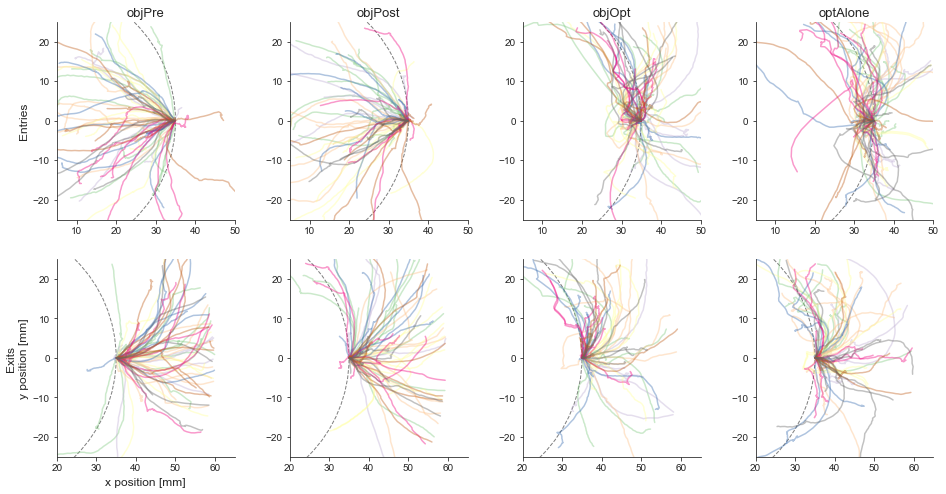

In [226]:
maxNpaths = 3
fig, axs = plt.subplots(2,len(condName),figsize=(4*len(condName),8))
xlimvals = [(5,50),(20,65)]

for tind,cond in enumerate(condName):
    entryPaths = np.load(analysisDir+'borderZone/'+genotype+'_entryTraj_'+cond+'_n'+str(numFlies)+'.npy')
    exitPaths = np.load(analysisDir+'borderZone/'+genotype+'_exitTraj_'+cond+'_n'+str(numFlies)+'.npy')
    pathsAll = [entryPaths, exitPaths]
    for i in range(2):
        for fly in range(numFlies):
            paths = pathsAll[i][fly]
            for p in range(min(len(paths),maxNpaths)):
                axs[i,tind].plot(paths[p][0],paths[p][1],'-',color=flyCMap.to_rgba(fly), alpha=0.4) 
        circle1 = plt.Circle((0, 0), visitRad, edgecolor='grey',fill=False, linewidth=1, linestyle='dashed')
        axs[i,tind].add_artist(circle1)
        axs[i,tind].set_aspect('equal')
        axs[i,tind].set_xlim(xlimvals[i])
        axs[i,tind].set_ylim(-25, 25)
        myAxisTheme(axs[i,tind])
        
    axs[0,tind].set_title(cond,fontsize=13)
axs[0,0].set_ylabel('Entries',fontsize=12)
axs[1,0].set_ylabel('Exits \ny position [mm]',fontsize=12)
axs[1,0].set_xlabel('x position [mm]',fontsize=12)

fig.savefig(analysisDir + 'borderZone/'  + genotype
               + '_'+str(maxNpaths)+'BorderTraj_allTrials_n'+ str(numFlies) +'.pdf', format='pdf') 

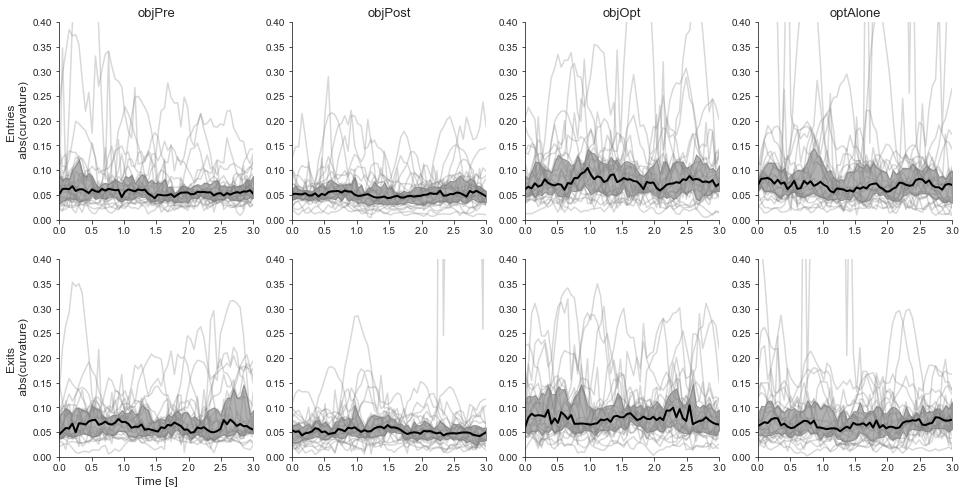

In [227]:
fig, axs = plt.subplots(2,len(condName),figsize=(4*len(condName),8))
minpath = 3

for tind,cond in enumerate(condName):
    entryPaths = np.load(analysisDir+'borderZone/'+genotype+'_entryTraj_'+cond+'_n'+str(numFlies)+'.npy')
    exitPaths = np.load(analysisDir+'borderZone/'+genotype+'_exitTraj_'+cond+'_n'+str(numFlies)+'.npy')
    pathsAll = [entryPaths, exitPaths]
    for i in range(2): # entries, exits
        perflyAvCurv = np.nan*np.ones((numFlies,windowSize))
        for fly in range(numFlies):
            paths = pathsAll[i][fly]
            flyAvCurv = np.nan*np.ones((len(paths),windowSize))
            for p in range(len(paths)):
                flyAvCurv[p,:] = abs(paths[p][2])
            if len(paths) >= minpath:
                perflyAvCurv[fly,:] = np.nanmean(flyAvCurv, axis=0)
            axs[i,tind].plot(timevec, perflyAvCurv[fly,:],'-',color='grey', alpha=0.3) 
        
        [qt25, qt50, qt75] = np.nanpercentile(perflyAvCurv,[25,50,75],axis=0)
        axs[i,tind].plot(timevec,qt50, linewidth=2,color='k', label='',)
        axs[i,tind].fill_between(timevec,qt25, qt75, color='k', linewidth=1,alpha=0.3)
        
        axs[i,tind].set_xlim(preWindow/fps,postWindow/fps)
        axs[i,tind].set_ylim(0, 0.4)
        myAxisTheme(axs[i,tind])
        
    axs[0,tind].set_title(cond,fontsize=13)
axs[0,0].set_ylabel('Entries \n abs(curvature)',fontsize=12)
axs[1,0].set_ylabel('Exits \n abs(curvature)',fontsize=12)
axs[1,0].set_xlabel('Time [s]',fontsize=12)

fig.savefig(analysisDir + 'borderZone/'  + genotype
               + '_BorderCurv_allTrials_n'+ str(numFlies) +'.pdf', format='pdf') 

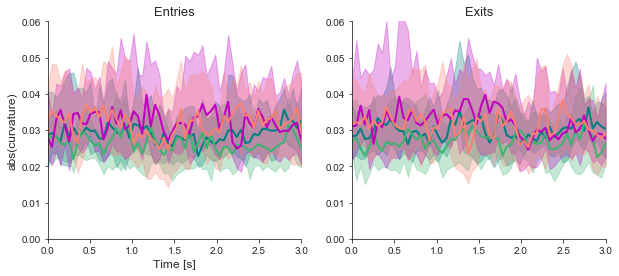

In [228]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
minpath = 3

for tind,cond in enumerate(condName):
    entryPaths = np.load(analysisDir+'borderZone/'+genotype+'_entryTraj_'+cond+'_n'+str(numFlies)+'.npy')
    exitPaths = np.load(analysisDir+'borderZone/'+genotype+'_exitTraj_'+cond+'_n'+str(numFlies)+'.npy')
    pathsAll = [entryPaths, exitPaths]
    for i in range(2): # entries, exits
        perflyAvCurv = np.nan*np.ones((numFlies,windowSize))
        for fly in range(numFlies):
            paths = pathsAll[i][fly]
            flyAvCurv = np.nan*np.ones((len(paths),windowSize))
            for p in range(len(paths)):
                flyAvCurv[p,:] = abs(paths[p][2])
            if len(paths) >= minpath:
                perflyAvCurv[fly,:] = np.nanmedian(flyAvCurv, axis=0)        
        [qt25, qt50, qt75] = np.nanpercentile(perflyAvCurv,[25,50,75],axis=0)
        axs[i].plot(timevec,qt50, linewidth=2,color=trialCol[tind], label='',)
        axs[i].fill_between(timevec,qt25, qt75, color=trialCol[tind], linewidth=1,alpha=0.3)
        
        axs[i].set_xlim(preWindow/fps,postWindow/fps)
        axs[i].set_ylim(0, 0.06)
        myAxisTheme(axs[i])
        
    axs[0].set_title('Entries',fontsize=13)
    axs[1].set_title('Exits',fontsize=13)
axs[0].set_ylabel('abs(curvature)',fontsize=12)
axs[0].set_xlabel('Time [s]',fontsize=12)

fig.savefig(analysisDir + 'borderZone/'  + genotype
               + '_BorderCurv2_allTrials_n'+ str(numFlies) +'.pdf', format='pdf') 

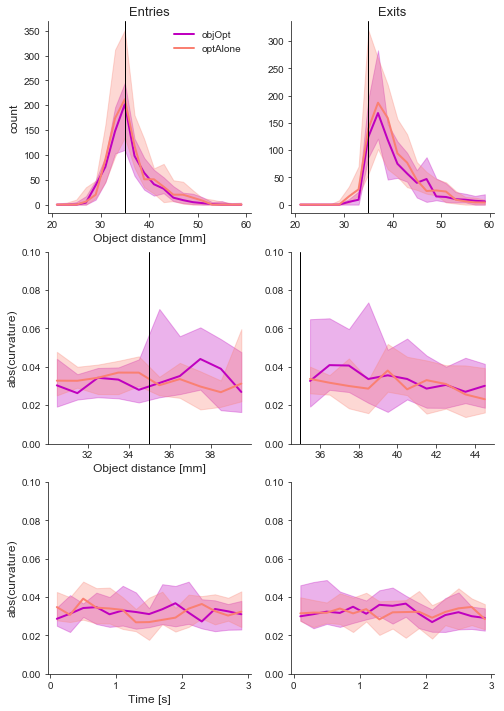

In [229]:
fig, axs = plt.subplots(3,2,figsize=(8,12))
minpath = 6

numBinsC = 20
rangeC = (20,60)

numBinsP = 10
rangeP = [(30,40),(35,45)]

numBinsT = 15
rangeT = (timevec[0],timevec[-1])

histstat = 'median'

for tind,cond in enumerate(condName):
    if tind<2: continue
    entryPaths = np.load(analysisDir+'borderZone/'+genotype+'_entryTraj_'+cond+'_n'+str(numFlies)+'.npy')
    exitPaths = np.load(analysisDir+'borderZone/'+genotype+'_exitTraj_'+cond+'_n'+str(numFlies)+'.npy')
    pathsAll = [entryPaths, exitPaths]
    for i in range(2): # entries, exits
        perflyAvPathCurv = np.nan*np.ones((numFlies,numBinsP))
        perflyAvTimeCurv = np.nan*np.ones((numFlies,numBinsT))
        perflyAvPathCount = np.nan*np.ones((numFlies,numBinsC))
        for fly in range(numFlies):
            paths = pathsAll[i][fly]
            flyAvCurv = np.nan*np.ones((len(paths),windowSize))
            flyAvDists = np.nan*np.ones((len(paths),windowSize))
            for p in range(len(paths)):
                flyAvCurv[p,:] = abs(paths[p][2])
                flyAvDists[p,:] = np.hypot(paths[p][0],paths[p][1])
            if len(paths) >= minpath:
                meanPathCurv, edgsP, binnum = sts.binned_statistic(flyAvDists.flatten(), flyAvCurv.flatten(),\
                                                                   statistic=histstat, bins=numBinsP, range=rangeP[i])
                perflyAvPathCurv[fly,:] = meanPathCurv #np.nanmean(flyAvCurv, axis=0)
                
                meanTimeCurv, edgsT, binnum = sts.binned_statistic(np.tile(timevec, len(paths)), flyAvCurv.flatten(),\
                                                                   statistic=histstat, bins=numBinsT, range=rangeT)
                perflyAvTimeCurv[fly,:] = meanTimeCurv
        
                meanPathCount, edgsC, binnum = sts.binned_statistic(flyAvDists.flatten(), flyAvCurv.flatten(),\
                                                                   statistic='count', bins=numBinsC, range=rangeC)
                perflyAvPathCount[fly,:] = meanPathCount
                
        tvect = edgsC[:-1]+np.diff(edgsC[:2])/2
        [qt25, qt50, qt75] = np.nanpercentile(perflyAvPathCount,[25,50,75],axis=0)
        axs[0,i].plot(tvect,qt50, linewidth=2,color=trialCol[tind], label=cond)
        axs[0,i].fill_between(tvect,qt25, qt75, color=trialCol[tind], linewidth=1,alpha=0.3)
        myAxisTheme(axs[0,i])
        
        tvect = edgsP[:-1]+np.diff(edgsP[:2])/2
        [qt25, qt50, qt75] = np.nanpercentile(perflyAvPathCurv,[25,50,75],axis=0)
        axs[1,i].plot(tvect,qt50, linewidth=2,color=trialCol[tind], label=cond)
        axs[1,i].fill_between(tvect,qt25, qt75, color=trialCol[tind], linewidth=1,alpha=0.3)
        myAxisTheme(axs[1,i])
        
        tvect = edgsT[:-1]+np.diff(edgsT[:2])/2
        [qt25, qt50, qt75] = np.nanpercentile(perflyAvTimeCurv,[25,50,75],axis=0)
        axs[2,i].plot(tvect,qt50, linewidth=2,color=trialCol[tind], label=cond)
        axs[2,i].fill_between(tvect,qt25, qt75, color=trialCol[tind], linewidth=1,alpha=0.3)
        
        #axs[i].set_xlim(preWindow/fps,postWindow/fps)
for i in range(2):
    #axs[0,i].set_ylim(0, 0.2)
    axs[1,i].set_ylim(0, 0.1)
    axs[2,i].set_ylim(0, 0.1)
    axs[0,i].axvline(visitRad,0,1,color='k', linewidth=1)
    axs[1,i].axvline(visitRad,0,1,color='k', linewidth=1)
    for ax in axs[:,i]:
        myAxisTheme(ax)
        
axs[0,0].set_title('Entries',fontsize=13)
axs[0,1].set_title('Exits',fontsize=13)
axs[0,0].set_ylabel('count',fontsize=12)
axs[1,0].set_ylabel('abs(curvature)',fontsize=12)
axs[2,0].set_ylabel('abs(curvature)',fontsize=12)
axs[0,0].set_xlabel('Object distance [mm]',fontsize=12)
axs[1,0].set_xlabel('Object distance [mm]',fontsize=12)
axs[2,0].set_xlabel('Time [s]',fontsize=12)
axs[0,0].legend(frameon=False)

fig.savefig(analysisDir + 'borderZone/'  + genotype
               + '_BorderCurvSummary_optTrials_n'+ str(numFlies) +'.pdf', format='pdf') 

objOpt
objOpt
objOpt
objOpt
optAlone
optAlone


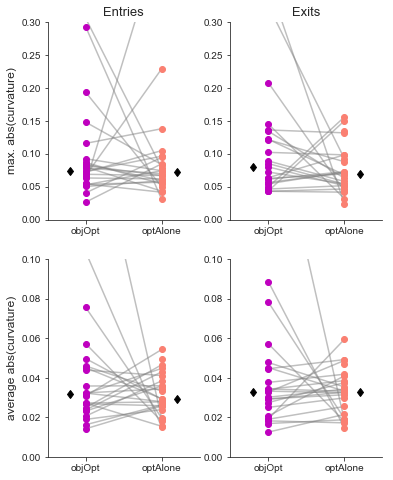

In [230]:
fig, axs = plt.subplots(2,2,figsize=(6,8))
minpath = 3

perflyMaxCurv = np.nan*np.ones((2, 2, numFlies))
perflyIntCurv = np.nan*np.ones((2, 2, numFlies))

for tind,cond in enumerate(condName[2:]):
    entryPaths = np.load(analysisDir+'borderZone/'+genotype+'_entryTraj_'+cond+'_n'+str(numFlies)+'.npy')
    exitPaths = np.load(analysisDir+'borderZone/'+genotype+'_exitTraj_'+cond+'_n'+str(numFlies)+'.npy')
    pathsAll = [entryPaths, exitPaths]
    for i in range(2): # entries, exits
        for fly in range(numFlies):
            paths = pathsAll[i][fly]
            flyAvCurv = np.nan*np.ones((len(paths),windowSize))
            for p in range(len(paths)):
                flyAvCurv[p,:] = abs(paths[p][2])
                
            if len(paths) >= minpath:
                perflyMaxCurv[tind,i,fly] = np.max(np.nanmedian(flyAvCurv, axis=0))
                perflyIntCurv[tind,i,fly] = np.nanmedian(np.nanmedian(flyAvCurv, axis=1), axis=0)
            else: print(cond)
                
for i in range(2):
    for fly in range(numFlies):
        axs[0,i].plot([0,1], [perflyMaxCurv[0,i,fly],perflyMaxCurv[1,i,fly]],'-', color='grey',alpha=0.5)
        axs[1,i].plot([0,1], [perflyIntCurv[0,i,fly],perflyIntCurv[1,i,fly]],'-', color='grey',alpha=0.5)
        
    axs[0,i].plot(np.ones(numFlies)*0, perflyMaxCurv[0,i,:],'o', color=trialCol[2])
    axs[0,i].plot(np.ones(numFlies), perflyMaxCurv[1,i,:],'o', color=trialCol[3])
    
    axs[0,i].plot(-0.2, np.nanmedian(perflyMaxCurv[0,i,:]),'d', color='k')
    axs[0,i].plot(1.2, np.nanmedian(perflyMaxCurv[1,i,:]),'d', color='k')
    
    axs[1,i].plot(np.ones(numFlies)*0, perflyIntCurv[0,i,:],'o', color=trialCol[2])
    axs[1,i].plot(np.ones(numFlies), perflyIntCurv[1,i,:],'o', color=trialCol[3])
    
    axs[1,i].plot(-0.2, np.nanmedian(perflyIntCurv[0,i,:]),'d', color='k')
    axs[1,i].plot(1.2, np.nanmedian(perflyIntCurv[1,i,:]),'d', color='k')
    
    
    for k in range(2):
        axs[k,i].set_xticks([0,1])
        axs[k,i].set_xticklabels(condName[2:])
        axs[k,i].set_xlim(-0.5, 1.5)
        myAxisTheme(axs[k,i])
axs[0,0].set_ylim(0, 0.3)
axs[0,1].set_ylim(0, 0.3)
axs[1,0].set_ylim(0, .1)
axs[1,1].set_ylim(0, .1)
axs[0,0].set_title('Entries',fontsize=13)
axs[0,1].set_title('Exits',fontsize=13)
axs[0,0].set_ylabel('max. abs(curvature)',fontsize=12)
axs[1,0].set_ylabel('average abs(curvature)',fontsize=12);

fig.savefig(analysisDir + 'borderZone/'  + genotype
               + '_BorderMaxAndMeanCurv_optTrials_n'+ str(numFlies) +'.pdf', format='pdf') 

### Analysis of path fragments
#### Consider paths of given length

In [231]:
# path length in mm
windowPre = 5
windowPost = 30
plotScale = 120/1.9

visitRad = rZone_rOuter

In [232]:
print('baseline:{}, max:{}, outer r:{}'.format(rZone_bl,rZone_max,rZone_rOuter))

baseline:0, max:30, outer r:40


In [233]:
def styleTracePlot(ax, titlestr):
    ax.plot([-plotScale,-plotScale+20],[-plotScale,-plotScale],'k', linewidth=3)
    ax.text(-plotScale+2,-plotScale+2,'20 mm')
    ax.plot(0,0,'ko') 
    ax.set_aspect('equal')
    ax.set_title(titlestr,fontsize=12)
    ax.set_axis_off()
    ax.set_xlim(-plotScale,plotScale)
    ax.set_ylim(-plotScale,plotScale)

objPre
objPost
objOpt
optAlone


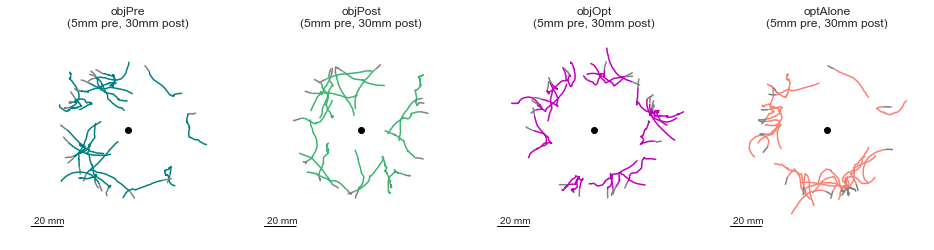

In [234]:
fig, axs = plt.subplots(1,4, figsize=(16,4))
trajPerFly = 1

for tind, trial in enumerate([0,1,2,3]):
    cond = condName[trial]
    print(cond)
    
    styleTracePlot(axs[tind], '{}\n({}mm pre, {}mm post)'.format(cond, windowPre,windowPost))            
    for fly in range(numFlies):
        querystring = '(flyID == "'+flyIDs[fly]+'") & (trial=='+str(trial+1)+')'
        xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        ttrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        xma = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yma = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        od = np.hypot(xma, yma)

        entries, exits, visitT,entryTime,exitTime = countvisits(od,ttrial,visitRad)

        evStart = np.where(entries)[0]
        prevSt = 0
        count = 1
        for i, es in enumerate(evStart):
            trunkated = False
            if i+1 < len(evStart) and evStart[i+1] - es == 1:
                continue

            xes = xma[es]
            yes = yma[es]

            # find start time
            pathLen = 0
            prei = 0
            while pathLen < windowPre:
                prei = prei+1
                if es-prei < 0 or es-prei < prevSt:
                    break # trunkated by start of trial or by previous event
                pathLen = pathLen + np.hypot(xtrial[es-prei]-xtrial[es-(prei-1)], ytrial[es-prei]-ytrial[es-(prei-1)])

            # find end time
            pathLen = 0
            posti = 0
            while pathLen < windowPost:  
                posti = posti+1
                if es+posti+1 > len(xtrial):
                    trunkated = True
                    break  # trunkated by end of trial or by next event
                if i+1 < len(evStart) and es+posti > evStart[i+1]:
                    trunkated = True
                    break
                pathLen = pathLen + np.hypot(xtrial[es+posti]-xtrial[es+(posti-1)], ytrial[es+posti]-ytrial[es+(posti-1)])

            if not trunkated:
                axs[tind].plot(xma[es-prei:es], yma[es-prei:es], color='grey')
                axs[tind].plot(xma[es:es+posti], yma[es:es+posti], color=trialCol[trial])
                #axs[tind].plot(xes, yes,'.', color='deeppink')

            prevSt = es

            count = count + 1
            if count > trajPerFly:
                break
    
fig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+'_pathAroundBorder_'+str(trajPerFly)+'perfly_pre'+
            str(windowPre)+'mm_post'+str(windowPost)+'mm_n'+ str(len(flyIDs))+'.pdf', format='pdf')

#### Center of mass analysis

objPre
objPost
objOpt
optAlone


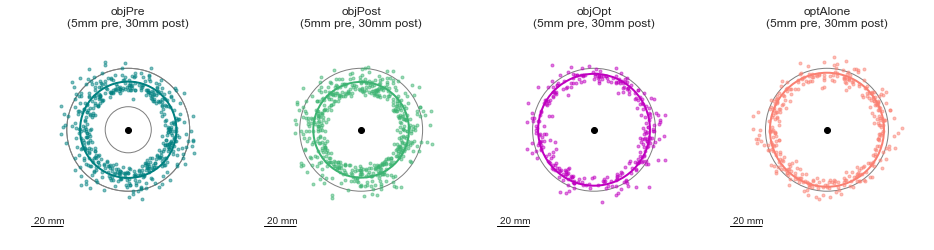

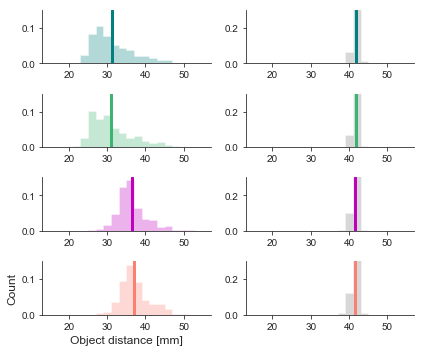

In [235]:
cmfig, axs = plt.subplots(1,4, figsize=(16,4))

histfig, histaxs = plt.subplots(4,2, figsize=(6,5))
pathRange = (15,55)
numBins = 20

for tind, trial in enumerate([0,1,2,3]):
    cond = condName[trial]
    print(cond)

    cmPost = []
    cmPre = []
    
    styleTracePlot(axs[tind], '{}\n({}mm pre, {}mm post)'.format(cond, windowPre,windowPost))            
    for fly in range(numFlies):
        querystring = '(flyID == "'+flyIDs[fly]+'") & (trial=='+str(trial+1)+')'
        xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        ttrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        xma = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yma = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        od = np.hypot(xma, yma)

        entries, exits, visitT,entryTime,exitTime = countvisits(od,ttrial,visitRad)

        evStart = np.where(entries)[0]
        prevSt = 0
        
        for i, es in enumerate(evStart):
            trunkated = False
            if i+1 < len(evStart) and evStart[i+1] - es == 1:
                continue

            xes = xma[es]
            yes = yma[es]

            # find start time
            pathLen = 0
            prei = 0
            while pathLen < windowPre:
                prei = prei+1
                if es-prei < 0 or es-prei < prevSt: break # trunkated by start of trial or by previous event
                pathLen = pathLen + np.hypot(xtrial[es-prei]-xtrial[es-(prei-1)], ytrial[es-prei]-ytrial[es-(prei-1)])

            # find end time
            pathLen = 0
            posti = 0
            while pathLen < windowPost:  
                posti = posti+1
                if es+posti+1 > len(xtrial):
                    trunkated = True
                    break  # trunkated by end of trial or by next event
                if i+1 < len(evStart) and es+posti > evStart[i+1]:
                    trunkated = True
                    break
                pathLen = pathLen + np.hypot(xtrial[es+posti]-xtrial[es+(posti-1)], ytrial[es+posti]-ytrial[es+(posti-1)])

            if not trunkated:
                cmx = np.mean(xma[es:es+posti])
                cmy = np.mean(yma[es:es+posti])
                cmPost.append((cmx,cmy))
                axs[tind].plot(cmx, cmy, '.', color=trialCol[trial],alpha=0.5)

                cmx = np.mean(xma[es-prei:es])
                cmy = np.mean(yma[es-prei:es])
                cmPre.append((cmx,cmy))

            prevSt = es

    cmPostx = [cm[0] for cm in cmPost]; cmPosty = [cm[1] for cm in cmPost]
    radDistances = np.hypot(cmPostx,cmPosty)
    circle = plt.Circle((0,0), np.nanmean(radDistances), edgecolor=trialCol[trial], 
                        facecolor='none',linewidth=2)
    axs[tind].add_artist(circle)
    circle = plt.Circle((0,0),40,edgecolor='grey',facecolor='none',linewidth=1)
    axs[tind].add_artist(circle)
    
    #hist figure
    histaxs[tind,0].hist(radDistances[~np.isnan(radDistances)], range=pathRange,bins=numBins, 
             color=trialCol[trial],histtype='stepfilled',alpha=0.3,density=True)
    histaxs[tind,0].axvline(np.nanmean(radDistances),0,1,color=trialCol[trial],linewidth=3)
    histaxs[tind,0].set_ylim(0,.15)
    
    cmPrex = [cm[0] for cm in cmPre]; cmPrey = [cm[1] for cm in cmPre]
    radDistances = np.hypot(cmPrex,cmPrey)
    histaxs[tind,1].hist(radDistances[~np.isnan(radDistances)], range=pathRange,bins=numBins, 
             color='grey',histtype='stepfilled',alpha=0.3,density=True)
    histaxs[tind,1].axvline(np.nanmean(radDistances),0,1,color=trialCol[trial],linewidth=3)
    histaxs[tind,1].set_ylim(0,.3)
    for ax in histaxs[tind,:]:
        myAxisTheme(ax)

for vr in [15,40]:
    circle = plt.Circle((0,0),vr,edgecolor='grey',facecolor='none',linewidth=1)
    axs[0].add_artist(circle)
    
cmfig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+'_cmAroundBorder_pre'+
            str(windowPre)+'mm_post'+str(windowPost)+'mm_n'+ str(len(flyIDs))+'.pdf', format='pdf')


histaxs[-1,0].set_xlabel('Object distance [mm]',fontsize=12)
histaxs[-1,0].set_ylabel('Count',fontsize=12)
histfig.tight_layout()

histfig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+'_cmHist_pre'+
            str(windowPre)+'mm_post'+str(windowPost)+'mm_n'+ str(len(flyIDs))+'.pdf', format='pdf')

#### End of path analysis

objPre
objPost
objOpt
optAlone


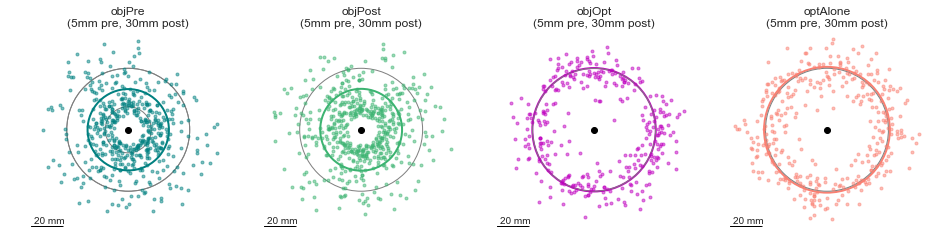

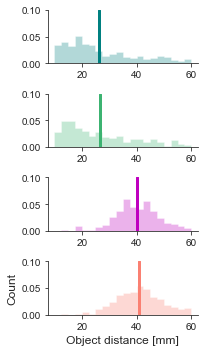

In [236]:
cmfig, axs = plt.subplots(1,4, figsize=(16,4))

histfig, histaxs = plt.subplots(4,1, figsize=(3,5))
pathRange = (10,60)
numBins = 20

for tind, trial in enumerate([0,1,2,3]):
    cond = condName[trial]
    print(cond)

    edPost = []
    
    styleTracePlot(axs[tind], '{}\n({}mm pre, {}mm post)'.format(cond, windowPre,windowPost))            
    for fly in range(numFlies):
        querystring = '(flyID == "'+flyIDs[fly]+'") & (trial=='+str(trial+1)+')'
        xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        ttrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        xma = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yma = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        od = np.hypot(xma, yma)

        entries, exits, visitT,entryTime,exitTime = countvisits(od,ttrial,visitRad)

        evStart = np.where(entries)[0]
        prevSt = 0
        
        for i, es in enumerate(evStart):
            trunkated = False
            if i+1 < len(evStart) and evStart[i+1] - es == 1:
                continue
            
            xes = xma[es]
            yes = yma[es]

            # find start time
            pathLen = 0
            prei = 0
            while pathLen < windowPre:
                prei = prei+1
                if es-prei < 0 or es-prei < prevSt: break # trunkated by start of trial or by previous event
                pathLen = pathLen + np.hypot(xtrial[es-prei]-xtrial[es-(prei-1)], ytrial[es-prei]-ytrial[es-(prei-1)])

            # find end time
            pathLen = 0
            posti = 0
            while pathLen < windowPost:  
                posti = posti+1
                if es+posti+1 > len(xtrial):
                    trunkated = True
                    break  # trunkated by end of trial or by next event
                if i+1 < len(evStart) and es+posti > evStart[i+1]:
                    trunkated = True
                    break
                pathLen = pathLen + np.hypot(xtrial[es+posti]-xtrial[es+(posti-1)], ytrial[es+posti]-ytrial[es+(posti-1)])

            if not trunkated:
                edx = xma[es+posti]
                edy = yma[es+posti]
                edPost.append((edx,edy))
                axs[tind].plot(edx, edy, '.', color=trialCol[trial],alpha=0.5)

            prevSt = es

    edPostx = [ed[0] for ed in edPost]; edPosty = [ed[1] for ed in edPost]
    radDistances = np.hypot(edPostx,edPosty)
    circle = plt.Circle((0,0), np.nanmean(radDistances), edgecolor=trialCol[trial], 
                        facecolor='none',linewidth=2)
    axs[tind].add_artist(circle)
    circle = plt.Circle((0,0),40,edgecolor='grey',facecolor='none',linewidth=1)
    axs[tind].add_artist(circle)
    
    #hist figure
    histaxs[tind].hist(radDistances[~np.isnan(radDistances)], range=pathRange,bins=numBins, 
             color=trialCol[trial],histtype='stepfilled',alpha=0.3,density=True)
    histaxs[tind].axvline(np.nanmean(radDistances),0,1,color=trialCol[trial],linewidth=3)
    histaxs[tind].set_ylim(0,.1)
    myAxisTheme(histaxs[tind])

for vr in [15,40]:
    circle = plt.Circle((0,0),vr,edgecolor='grey',facecolor='none',linewidth=1)
    axs[0].add_artist(circle)
    
cmfig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+'_endofpathAroundBorder_pre'+
            str(windowPre)+'mm_post'+str(windowPost)+'mm_n'+ str(len(flyIDs))+'.pdf', format='pdf')


histaxs[-1].set_xlabel('Object distance [mm]',fontsize=12)
histaxs[-1].set_ylabel('Count',fontsize=12)
histfig.tight_layout()

histfig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+'_endofpathHist_pre'+
            str(windowPre)+'mm_post'+str(windowPost)+'mm_n'+ str(len(flyIDs))+'.pdf', format='pdf')

#### Visit counts

In [237]:
visitRads = np.arange(15,60,5)
visitCounts = np.zeros((len(visitRads),len(condName),numFlies))

for tind, trial in enumerate([0,1,2,3]):
    cond = condName[trial]
    for fly in range(numFlies):
        querystring = '(flyID == "'+flyIDs[fly]+'") & (trial=='+str(trial+1)+')'
        ttrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        xma = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yma = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        od = np.hypot(xma, yma)
        
        for i, vr in enumerate(visitRads):
            entries, exits, visitT,entryTime,exitTime = countvisits(od,ttrial,vr)
            visitCounts[i,tind,fly] = sum(entries)


Visit radius = 15mm

t-test: virtual heat trials
(0.5144957554275265, 0.6116110871365434)
t-test: pre/post trials
(-0.9268802268105057, 0.36321654511080703)

Visit radius = 40mm

t-test: virtual heat trials
(-1.4615892877640349, 0.15682464409135263)
t-test: pre/post trials
(-0.8193699486866158, 0.4206380577797283)


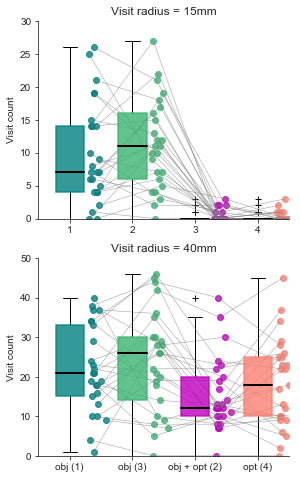

In [239]:
from plottingUtilities.objectPreferencePlots import prettyBoxPlot, simpleBoxPlot
import scipy.stats as sts

offsets = np.ones(4)*1.4

boxalpha = 0.8
linealpha=0.8

fig, axs = plt.subplots(2,1,figsize=(4.5,8))
for i,vr in enumerate([0,5]):
    objBoxPlt = prettyBoxPlot(axs[i],trialCol, boxalpha, linealpha,
                              visitCounts[vr,:,:].T,flyIDs, offsets, trialName, plotLabels=False)
    axs[i].set_title('Visit radius = {}mm'.format(visitRads[vr]))
    axs[i].set_ylabel('Visit count')
    
    print('\nVisit radius = {}mm\n'.format(visitRads[vr]))
    print('t-test: virtual heat trials')
    stat, p = sts.ttest_1samp(visitCounts[vr,2,:]-visitCounts[vr,3,:], popmean=0)
    print(stat, p)
    print('t-test: pre/post trials'.format(visitRads[vr]))
    stat, p = sts.ttest_1samp(visitCounts[vr,0,:]-visitCounts[vr,1,:], popmean=0)
    print(stat, p)

axs[0].set_ylim(0,30)
axs[1].set_ylim(0,50)
fig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+
            '_visitCountBoxplots_n'+ str(len(flyIDs))+'.pdf', format='pdf')

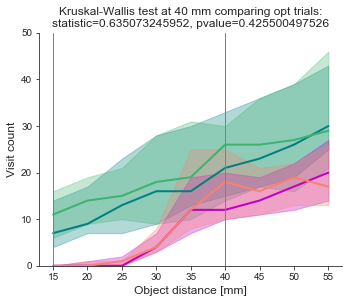

In [240]:
fig, ax = plt.subplots(figsize=(5,4))
for tind, trial in enumerate([0,1,2,3]):
    [qt25, qt50, qt75] = np.nanpercentile(visitCounts[:,tind,:],[25,50,75],axis=1)
    ax.plot(visitRads,qt50, linewidth=2,color=trialCol[tind], label=cond)
    ax.fill_between(visitRads,qt25, qt75, color=trialCol[tind], linewidth=1,alpha=0.3)
    
for vr in [15,40]:
    ax.axvline(vr,0,1,color='grey',linewidth=1)
ax.set_xlabel('Object distance [mm]',fontsize=12)
ax.set_ylabel('Visit count',fontsize=12)
ax.set_ylim(0,50)
myAxisTheme(ax)
fig.tight_layout()

import scipy.stats as sts
stat, p = sts.kruskal(visitCounts[5,2,:], visitCounts[5,3,:])
ax.set_title('Kruskal-Wallis test at 40 mm comparing opt trials:\nstatistic={}, pvalue={}'.format(stat,p))


fig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+
            '_visitCount_n'+ str(len(flyIDs))+'.pdf', format='pdf')

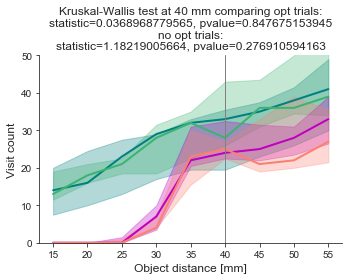

In [241]:
visitCountsFilt = visitCounts[:,:,visitCounts[5,2,:]>=20]
fig, ax = plt.subplots(figsize=(5,4))
for tind, trial in enumerate([0,1,2,3]):
    [qt25, qt50, qt75] = np.nanpercentile(visitCountsFilt[:,tind,:],[25,50,75],axis=1)
    ax.plot(visitRads,qt50, linewidth=2,color=trialCol[tind], label=cond)
    ax.fill_between(visitRads,qt25, qt75, color=trialCol[tind], linewidth=1,alpha=0.3)
    
ax.axvline(40,0,1,color='grey',linewidth=1)
ax.set_xlabel('Object distance [mm]',fontsize=12)
ax.set_ylabel('Visit count',fontsize=12)
ax.set_ylim(0,50)
myAxisTheme(ax)
fig.tight_layout()

import scipy.stats as sts
stat1, p1 = sts.kruskal(visitCountsFilt[5,2,:], visitCountsFilt[5,3,:])
stat2, p2 = sts.kruskal(visitCountsFilt[5,0,:], visitCountsFilt[5,1,:])
ax.set_title('Kruskal-Wallis test at 40 mm comparing opt trials:\nstatistic={}, pvalue={}\nno opt trials:\nstatistic={}, pvalue={}'.format(stat1,p1, stat2,p2))

fig.tight_layout()
fig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+
            '_visitCountFiltMin20at40mm_n'+ str(len(flyIDs))+'.pdf', format='pdf')

#### Coverage of path along radial distance axis from object

In [242]:
entryRad = rZone_rOuter+15
histRange = (10,entryRad)
histBins = np.diff(histRange)[0]/5
perFlyDistAv = np.zeros((4, numFlies, histBins))

windowPost = 55

In [243]:
for tind, trial in enumerate([0,1,2,3]):
    cond = condName[trial]
    print(cond)
    
    for fly in range(numFlies):
        querystring = '(flyID == "'+flyIDs[fly]+'") & (trial=='+str(trial+1)+')'
        xtrial = FOAllFlies_df.query(querystring)['xPos'].values.squeeze()
        ytrial = FOAllFlies_df.query(querystring)['yPos'].values.squeeze()
        ttrial = FOAllFlies_df.query(querystring)['time'].values.squeeze()
        xma = FOAllFlies_df.query(querystring)['xPosInMiniarena'].values.squeeze()
        yma = FOAllFlies_df.query(querystring)['yPosInMiniarena'].values.squeeze()
        od = np.hypot(xma, yma)

        entries, exits, visitT,entryTime,exitTime = countvisits(od,ttrial,entryRad)

        evStart = np.where(entries)[0]
        prevSt = 0
        flypaths = []
        for i, es in enumerate(evStart):
            trunkated = False
            if i+1 < len(evStart) and evStart[i+1] - es == 1:
                continue

            xes = xma[es]
            yes = yma[es]
            
            # find end time
            pathLen = 0
            posti = 0
            while pathLen < windowPost:  
                posti = posti+1
                if es+posti+1 > len(xtrial):
                    trunkated = True
                    break  # trunkated by end of trial or by next event
                if i+1 < len(evStart) and es+posti > evStart[i+1]:
                    trunkated = True
                    break
                pathLen = pathLen + np.hypot(xtrial[es+posti]-xtrial[es+(posti-1)], ytrial[es+posti]-ytrial[es+(posti-1)])

            if not trunkated:
                flypaths.append(od[es:es+posti])

            prevSt = es
        flypaths = [item for sublist in flypaths for item in sublist]
        n, ed = np.histogram(np.asarray(flypaths), bins=histBins, range=histRange, normed=True)
        perFlyDistAv[tind, fly, :] = n

objPre
objPost
objOpt
optAlone


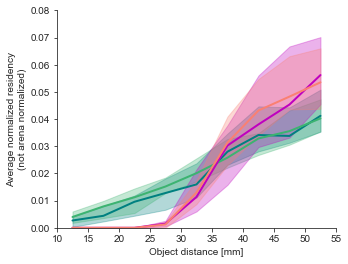

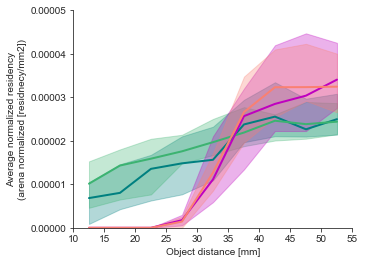

In [244]:
fig, axs = plt.subplots(1,1, figsize=(5,4))

edges = ed[:-1]+(np.diff(ed[:2]))/2.
for trial in range(4):
    [qt25, qt50, qt75] = np.nanpercentile(perFlyDistAv[trial,:,:].squeeze(),[25,50,75],axis=0)

    axs.plot(edges,qt50, linewidth=2,color=trialCol[trial], label=cond)
    axs.fill_between(edges,qt25, qt75, color=trialCol[trial], linewidth=1,alpha=0.3)
axs.set_xlim(histRange)
axs.set_ylim(0,.08)
axs.set_xlabel('Object distance [mm]')
axs.set_ylabel('Average normalized residency\n(not arena normalized)')
myAxisTheme(axs)

fig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+'_residencyAroundBorder_post'
            +str(windowPost)+'mm_n'+ str(len(flyIDs))+'.pdf', format='pdf')


fig, axs = plt.subplots(1,1, figsize=(5,4))

edges = ed[:-1]+(np.diff(ed[:2]))/2.
# normalisation factor for cirle area rings
areaNormA = np.square(np.linspace(histRange[0], histRange[1], histBins + 1).astype('float')) * np.pi
areaNorm = areaNormA[1:] - areaNormA[:-1]

for trial in range(4):
    [qt25, qt50, qt75] = np.nanpercentile(perFlyDistAv[trial,:,:].squeeze()/areaNorm,[25,50,75],axis=0)

    axs.plot(edges,qt50, linewidth=2,color=trialCol[trial], label=cond)
    axs.fill_between(edges,qt25, qt75, color=trialCol[trial], linewidth=1,alpha=0.3)
axs.set_xlim(histRange)
axs.set_ylim(0,.00005)
axs.set_xlabel('Object distance [mm]')
axs.set_ylabel('Average normalized residency\n(arena normalized [residnecy/mm2])')
myAxisTheme(axs)

fig.savefig(analysisDir + 'borderZone/'+genotype +'_'+flyIDs[0][0]+'_residencyAroundBorderNorm_post'
            +str(windowPost)+'mm_n'+ str(len(flyIDs))+'.pdf', format='pdf')